# Projet 9 : Prédisez la demande en électricité 

## Scénario

**Prérequis**

Pour effectuer ce projet, vous devrez maîtriser la manipulation de données en Python ou R, connaître la modélisation de type régression linéaire, ainsi que les différentes modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)
<br><br>
**Mise en situation**

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !


## Les données

Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette [page](https://www.rte-france.com/eco2mix/telecharger-les-indicateurs).

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : [https://cegibat.grdf.fr/simulateur/calcul-dju](https://cegibat.grdf.fr/simulateur/calcul-dju)

## Vos missions

Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

<ol><li>Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
<li>Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
<li>Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.</li></ol>

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

## Environnement

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as ssd
import pingouin as pg
import os

In [2]:
path = '../P9/P9_00_datasets/'

## Mission 1

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire

### Données en énergie - RTE

In [3]:
df = pd.read_csv(path + 'eCO2mix_RTE_energie_M.csv', sep=';')
df.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0,NaN
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0,NaN
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0,NaN
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0,NaN
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0,NaN


In [4]:
#energy data (consolidated and final): they relate to France and the 12 administrative regions
df = df[df['Territoire'] == 'France'].drop('Unnamed: 22', axis=1).reset_index(drop=True)

#brief data description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      118 non-null    object 
 1   Qualité                                   118 non-null    object 
 2   Territoire                                118 non-null    object 
 3   Production totale                         118 non-null    int64  
 4   Production nucléaire                      118 non-null    float64
 5   Production thermique totale               118 non-null    int64  
 6   Production thermique charbon              118 non-null    float64
 7   Production thermique fioul                118 non-null    int64  
 8   Production thermique gaz                  118 non-null    int64  
 9   Production hydraulique                    118 non-null    int64  
 10  Production éolien                     

📌

[Description des données en énergie](https://assets.rte-france.com/prod/public/2020-07/éCO2mix%20-%20Description%20des%20fichiers%20des%20données%20en%20énergie.pdf)

Production totale et consommation totale en GWh

In [5]:
#convert the month column to date time format
df['Mois'] = df['Mois'].astype('datetime64')

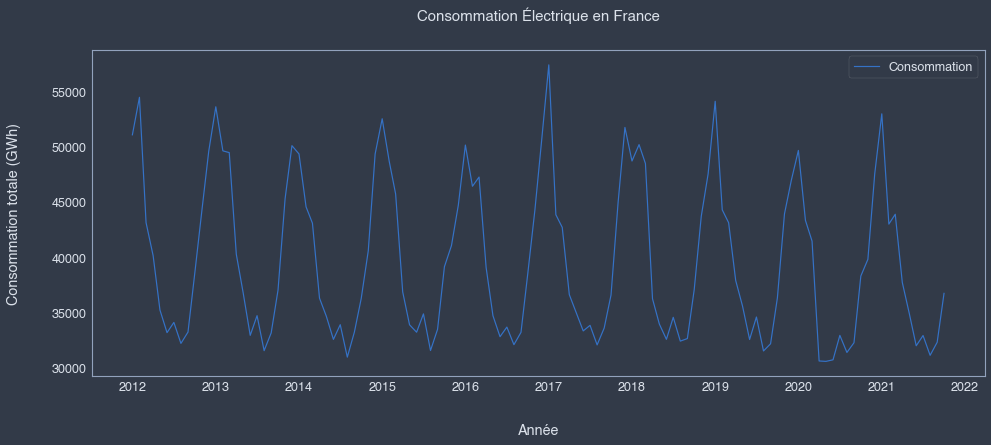

In [6]:
#dataviz
plt.figure(figsize=(16,6))

sns.lineplot(data=df, x='Mois', y='Consommation totale')

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)

plt.show()

### Données effet température

📌 

Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18°C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

2 méthodes de calculs sont proposées : Météo (méthode simplifiée) et Professionnels de l’énergie (méthode plus complexe pour mieux prendre en compte les débuts et fins de saisons de chauffe/climatisation).

In [7]:
#get the current working directory (CWD)
cwd = os.getcwd()
     
#changing the CWD
cwd = os.chdir(cwd + '/P9_00_datasets')

#get all the files needed
files = [file for file in os.listdir(cwd) if file.startswith("calcul_")]

print ("Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : ")
print("")
for file in files :
    print (file)

Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : 

calcul_DJU_29_12_2021_MACON_71.xlsx
calcul_DJU_29_12_2021_STBRIEUC_22.xlsx
calcul_DJU_29_12_2021_LA_ROCHELLE_17.xlsx
calcul_DJU_29_12_2021_TARBES_65.xlsx
calcul_DJU_29_12_2021_MONTPELLIER_34.xlsx
calcul_DJU_29_12_2021_ORLY_91.xlsx
calcul_DJU_29_12_2021_STDIZIER_52.xlsx
calcul_DJU_29_12_2021_ORANGE_84.xlsx


In [8]:
#read & concatenate the files of the different regions - 1 city per region
dju = pd.DataFrame()

for file in files :
    data = pd.read_excel(file, header=11, index_col=0)
    dju = pd.concat((dju,data))
    
#clean 
del cwd, file, files, data, 

/Users/Gladou/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
#national average
dju = dju.groupby(dju.index).mean()
dju.head()

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2012,354.2500,452.9875,235.6375,220.3250,104.1875,45.4375,32.3875,18.3875,71.2875,140.0875,263.6500,342.1625,2280.6875
2013,406.2500,390.8500,331.1375,221.5375,169.7375,65.1750,13.1375,26.1125,55.7250,98.8000,293.3875,353.8500,2425.6625
2014,317.8875,282.1250,258.9750,155.7500,118.8625,38.3625,21.8875,36.4125,44.8625,91.5875,205.0500,353.3500,1925.0625
2015,378.5000,363.3750,274.0375,171.4250,103.7250,38.2375,17.6875,22.8250,80.0875,171.0750,204.7875,254.6625,2080.3750
2016,334.7125,305.3375,312.6250,210.4125,116.9625,40.4375,22.7625,22.5250,38.8875,168.8500,268.1000,378.7625,2220.3250


In [10]:
#reset_index() for remove multi indexing
dju = pd.DataFrame(dju.stack()).reset_index()

#convert dtype column int to obj
dju['level_0'] = dju['level_0'].astype(object)

#replace values for convert in date time format
dju['level_1'] = dju['level_1'].replace({'JAN' : 1, 
                                         'FÉV' : 2, 
                                         'MAR' : 3,
                                         'AVR' : 4,
                                         'MAI' : 5,
                                         'JUN' : 6,
                                         'JUI' : 7,
                                         'AOÛ' : 8,
                                         'SEP' : 9,
                                         'OCT' : 10,
                                         'NOV' : 11,
                                         'DÉC' : 12})

#create a 'Month' column to merge with the original df later
dju['Mois'] = 0

for i in range(0, len(dju)) : 
    dju.loc[i, 'Mois'] = str(dju['level_0'][i]) + ' - ' + str(dju['level_1'][i])
    i += 1
    
# delete total line
dju = dju[dju['level_1'] != 'Total']

#convert this new column as datetime format
dju['Mois'] = dju['Mois'].astype('datetime64')

#clean
dju = dju[['Mois', 0]].rename(columns={0 : 'DJU'})

df = df.merge(dju, on='Mois', how='left')

### Correction des données

#### Régression Linéaire 

In [11]:
#set explanatory and dependent variables
DJU = df['DJU']
Consommation_totale = df['Consommation totale']

#linear regression
lr = smf.ols('Consommation_totale ~ DJU', data=df).fit()
print(lr.summary())

#clean
del DJU, Consommation_totale

                             OLS Regression Results                            
Dep. Variable:     Consommation_totale   R-squared:                       0.928
Model:                             OLS   Adj. R-squared:                  0.927
Method:                  Least Squares   F-statistic:                     1491.
Date:                 Fri, 31 Dec 2021   Prob (F-statistic):           4.81e-68
Time:                         08:20:15   Log-Likelihood:                -1057.7
No. Observations:                  118   AIC:                             2119.
Df Residuals:                      116   BIC:                             2125.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.058e+04    291.702    104.82

📌

Variance totale expliquée par le modèle : 93%

In [12]:
#new column for corrected consumption
df['Consommation totale corrigée'] = df['Consommation totale'] - (df['DJU'] * lr.params['DJU']).astype(int)

#### Analyse des résultats du modèle

##### Normalité des résidus

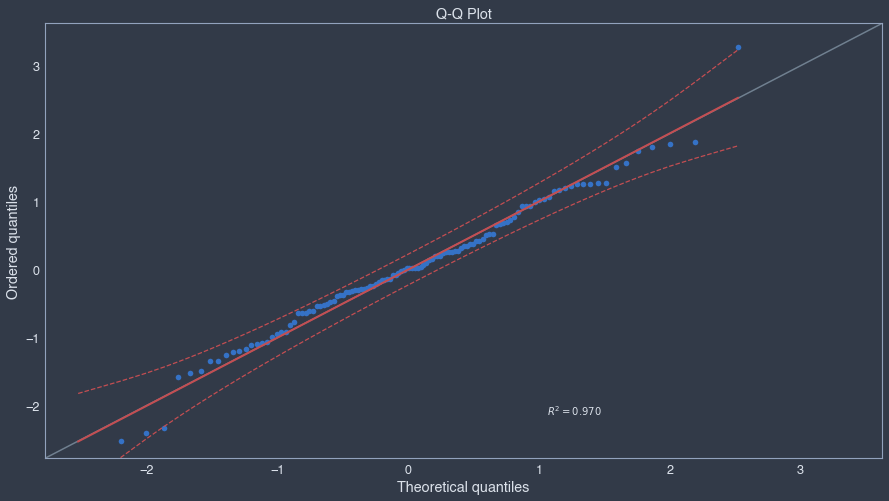

In [13]:
pg.qqplot(lr.resid, dist='norm', figsize=(15,8));

In [14]:
#D’Agostino and Pearson’s test
#more appropriate for large samples
pg.normality(lr.resid, method='normaltest')

,W,pval,normal
0,8.736512,0.012673,False


<div class="admonition note alert alert-info" style="color:#4cb2ff">
Although the D'Agostino Pearson's test leads us to reject the normality hypothesis, the fact that the residuals are not very different from a symmetric distribution (QQ-plot), and the fact that the sample is of sufficient size (greater than 30) allow us to say that the results obtained by the Gaussian linear model are not absurd.
</div>

##### Homoscedasticité des résidus

In [21]:
variables = lr.model.exog
_, pval, __, f_pval = ssd.het_breuschpagan(lr.resid, variables)

print("Breusch Pagan's test p-value :", pval)

#clean
del variables, _, pval, __, f_pval

Breusch Pagan's test p-value : 0.38833637026642454


<div class="admonition note alert alert-info" style="color:#4cb2ff">
The p-value here is more than 5%, we can't reject the hypothesis H0 that the variances are constant (the homoscedasticity hypothesis).  
</div>

###  Datavisualisation

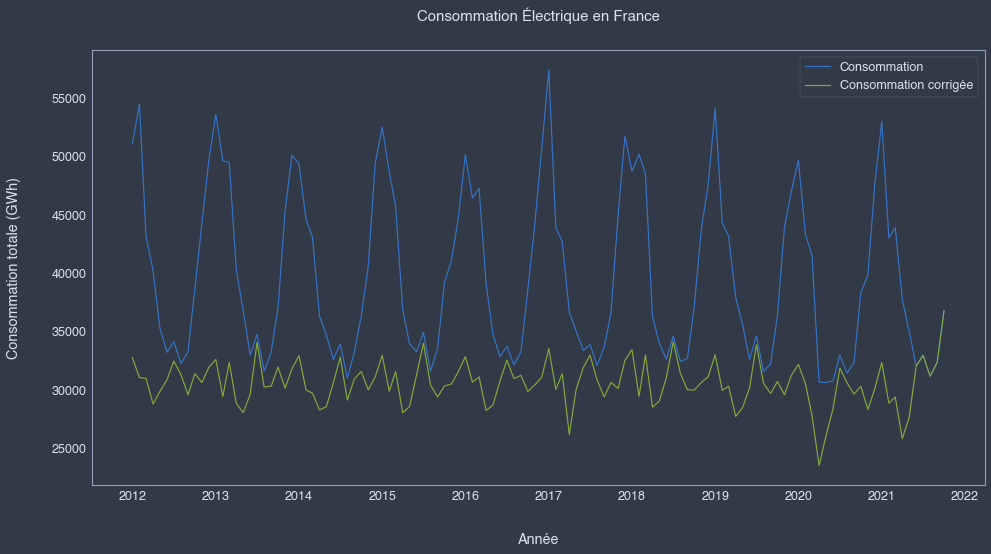

In [32]:
#dataviz
plt.figure(figsize=(16,8))

sns.lineplot(data=df, x='Mois', y='Consommation totale')
sns.lineplot(data=df, x='Mois', y='Consommation totale corrigée')

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation', 'Consommation corrigée'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)

plt.show()

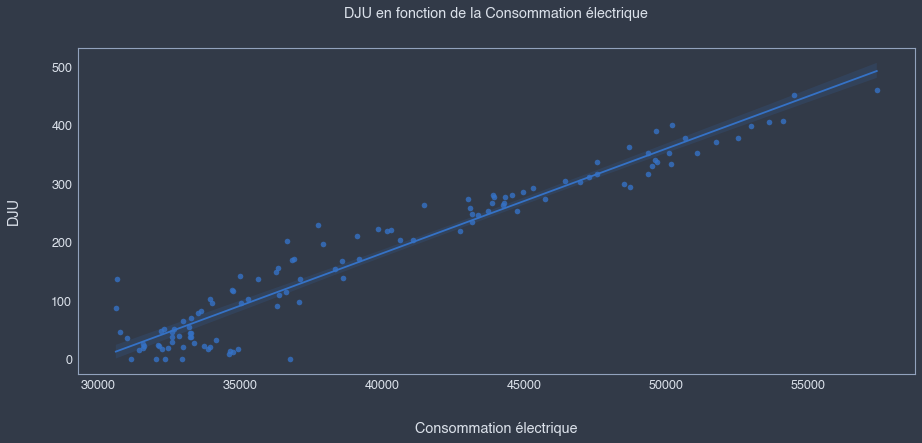

In [36]:
plt.figure(figsize=(15,6))

sns.regplot(x='Consommation totale', y='DJU', data=df)
plt.xlabel('Consommation électrique', labelpad=30)
plt.ylabel('DJU', labelpad=30)
plt.title("DJU en fonction de la Consommation électrique", pad=30)

plt.show()
